In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision

In [2]:
print(torch.__version__)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    device1 = torch.device('cuda')
else:
    print('CPU')
    device1 = torch.device('cpu')

1.10.2
NVIDIA GeForce GTX 1070 Ti


In [4]:
import math

from matplotlib import pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

In [5]:
# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

In [6]:
choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

In [7]:
# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

In [8]:
choc_data.dtypes

maker                object
specific_origin      object
reference_number      int64
review_date           int64
cocoa_percent        object
maker_location       object
rating              float64
bean_type            object
broad_origin         object
dtype: object

In [9]:
# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

In [10]:
#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

In [11]:
#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

In [12]:
# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

In [13]:
def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [14]:
choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

In [15]:
#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

In [16]:
#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

In [17]:
#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

In [18]:
# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

In [19]:
# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

In [20]:
# Save the original column names
original_cols = choc_data.columns.values

In [21]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [22]:
choc_data.tail()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
1790,Zotter,Peru,647,2011,70.00,Austria,3.75,Blend,Peru
1791,Zotter,Congo,749,2011,65.00,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.00,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.00,Austria,3.25,Blend,India
1794,Zotter,"Brazil,Mitzi Blue",486,2010,65.00,Austria,3.00,Blend,Brazil


## Preprocess Data

C:\ProgramData\Anaconda3\envs\xev-gpu-t1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='review_date', ylabel='Density'>

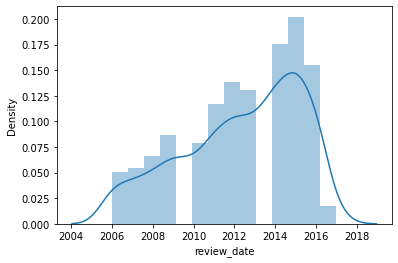

In [23]:
sns.distplot(choc_data['review_date'])

C:\ProgramData\Anaconda3\envs\xev-gpu-t1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

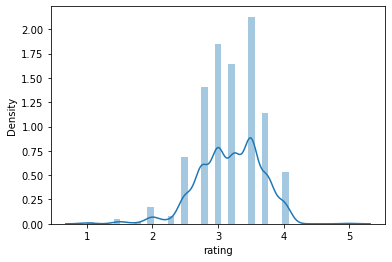

In [24]:
# check the distribution
sns.distplot(choc_data['rating'])

In [25]:
# its a Gaussian! So, use z-score to normalize the data
choc_data['rating_norm'] = (choc_data['rating'] - choc_data['rating'].mean()
                           ) / choc_data['rating'].std()

C:\ProgramData\Anaconda3\envs\xev-gpu-t1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cocoa_percent', ylabel='Density'>

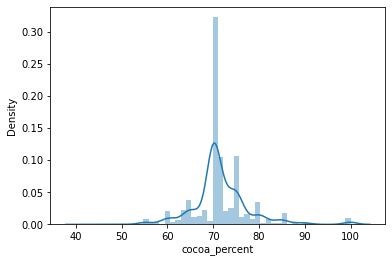

In [26]:
sns.distplot(choc_data['cocoa_percent'])

In [27]:
choc_data['cocoa_percent_norm'] = (
    choc_data['cocoa_percent'] -
    choc_data['cocoa_percent'].mean()) / choc_data['cocoa_percent'].std()

In [28]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18,-1.38
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27


In [29]:
# Load lat long data

countries_info = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/countries_lat_long.csv", sep=",", encoding='latin-1')

In [30]:
#Join the chocolate review and geographic information tables on maker country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="maker_location", right_on="name")
choc_data.rename(
    columns={
        "longitude": "maker_long",
        "latitude": "maker_lat"
    }, inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

In [31]:
#Join the chocolate review and geographic information tables on origin country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="broad_origin", right_on="name")
choc_data.rename(
    columns={
        "longitude": "origin_long",
        "latitude": "origin_lat"
    },
    inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27,46.23,2.21,8.62,0.82
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27,46.23,2.21,8.62,0.82
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27,46.23,2.21,8.62,0.82
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27,46.23,2.21,-9.19,-75.02
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru,1.70,-0.27,46.23,2.21,-9.19,-75.02


C:\ProgramData\Anaconda3\envs\xev-gpu-t1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maker_lat', ylabel='Density'>

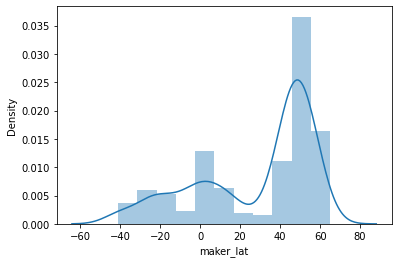

In [32]:
sns.distplot(choc_data['maker_lat'])

In [33]:
numQuantiles = 20
colsQuantiles = ['maker_lat', 'maker_long', 'origin_lat', 'origin_long']

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for string in colsQuantiles:
  choc_data[string] = createQuantiles(choc_data[string], numQuantiles)
  
choc_data.tail()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
782,Mesocacao,Honduras,1347,2014,70.00,Honduras,3.50,Blend,Honduras,0.66,-0.27,6,0,10,1
783,Malagos,"Davao,Mt Talamo foothills",1121,2013,65.00,Philippines,3.50,Trinitario,Philippines,0.66,-1.06,6,13,10,12
784,Mesocacao,El Salvador,1494,2015,80.00,Honduras,2.75,Blend,El Salvador,-0.91,1.31,6,0,10,0
785,Mesocacao,El Salvador,1494,2015,70.00,Honduras,3.00,Blend,El Salvador,-0.39,-0.27,6,0,10,0
786,Tan Ban Skrati,"Paramaribo,batch 20160043,01",1868,2016,70.00,Suriname,3.25,Trinitario,Suriname,0.13,-0.27,4,4,7,8


In [34]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr


for string in colsQuantiles:
  choc_data[string] = minMaxScaler(choc_data[string])

In [35]:
# duplicate the "maker" feature since it's removed by one-hot encoding function
choc_data['maker2'] = choc_data['maker']
choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'])

# similarly, duplicate the "bean_type" feature
choc_data['bean_type2'] = choc_data['bean_type']
choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'])

In [36]:
# Split dataframe into two frames: Original data and data for clustering
choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
choc_data.drop(columns=original_cols, inplace=True)

# get_dummies returned ints for one-hot encoding but we want floats so divide by
# 1.0
# Note: In the latest version of "get_dummies", you can set "dtype" to float
choc_data = choc_data / 1.0

In [37]:
choc_data.tail()

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
782,0.66,-0.27,0.40,0.00,0.77,0.08,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,0.66,-1.06,0.40,0.87,0.77,0.92,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
784,-0.91,1.31,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
785,-0.39,-0.27,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
786,0.13,-0.27,0.27,0.27,0.54,0.62,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [38]:
choc_data_backup

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru
...,...,...,...,...,...,...,...,...,...
782,Mesocacao,Honduras,1347,2014,70.00,Honduras,3.50,Blend,Honduras
783,Malagos,"Davao,Mt Talamo foothills",1121,2013,65.00,Philippines,3.50,Trinitario,Philippines
784,Mesocacao,El Salvador,1494,2015,80.00,Honduras,2.75,Blend,El Salvador
785,Mesocacao,El Salvador,1494,2015,70.00,Honduras,3.00,Blend,El Salvador


## Calculate Manual Similarity

In [40]:
def getSimilarity(obj1, obj2):
  len1 = len(obj1.index)
  len2 = len(obj2.index)
  if not (len1 == len2):
    print ("Error: Compared objects must have same number of features.")
    sys.exit()
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / 10.0)
    similarity = 1 - math.sqrt(similarity)
    return similarity

In [46]:
choc1 = 0  #@param
chocsToCompare = [1, 4]  #@param

print("Similarity between chocolates " + str(choc1) + " and ...")

for ii in range(chocsToCompare[0], chocsToCompare[1] + 1):
  print(str(ii) + ": " + str(
      getSimilarity(choc_data.loc[choc1], choc_data.loc[ii])))

print("\n\nFeature data for chocolate " + str(choc1))
print(choc_data_backup.loc[choc1:choc1, :])
print("\n\nFeature data for compared chocolates " + str(chocsToCompare))
print(choc_data_backup.loc[chocsToCompare[0]:chocsToCompare[1], :])

Similarity between chocolates 0 and ...
1: 0.8346304947537501
2: 0.5038914842612502
3: 0.4555557720237352
4: 0.14327793910574316


Feature data for chocolate 0
      maker specific_origin  reference_number  review_date  cocoa_percent  \
0  A. Morin           Kpime              1676         2015          70.00   

  maker_location  rating bean_type broad_origin  
0         France    2.75     Blend         Togo  


Feature data for compared chocolates [1, 4]
      maker specific_origin  reference_number  review_date  cocoa_percent  \
1  A. Morin          Atsane              1676         2015          70.00   
2  A. Morin           Akata              1680         2015          70.00   
3  A. Morin          Quilla              1704         2015          70.00   
4  A. Morin         Pablino              1319         2014          70.00   

  maker_location  rating bean_type broad_origin  
1         France    3.00     Blend         Togo  
2         France    3.50     Blend         Togo  
3  

In [48]:
#@title Run cell to setup functions
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities


def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids


def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df


def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids


def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print('Total distance:' + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df, centroids]

In [49]:
k = 30  #@param

feature_cols = choc_data.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_data['pt2centroid'] = 2
[choc_data, centroids] = kmeans(choc_data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
choc_data.head()

Total distance:421.84834741579056
Total distance:337.1442888640921
Total distance:328.95531758116954
Total distance:325.6086459092985
Total distance:324.31856492192975
Total distance:323.9715328029546
Total distance:323.599051237091
Total distance:323.5584128851141
k-means converged for 30 clusters after 8 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA",centroid,pt2centroid
0,-0.91,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,0.33
1,-0.39,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,0.35
2,0.66,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,0.36
3,0.66,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,0.35
4,1.70,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8,0.36


In [51]:
centroids

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
0,0.76,-1.09,0.35,0.56,0.26,0.80,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.19,-0.34,0.51,0.44,0.51,0.52,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,-0.28,-0.09,0.87,0.60,0.50,0.35,0.00,0.00,0.00,0.00,...,0.00,0.00,0.10,0.00,0.10,0.00,0.40,0.00,0.00,0.00
3,0.56,0.96,0.55,0.51,0.55,0.54,0.00,0.00,0.08,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,0.00
4,-1.49,4.33,0.50,0.35,0.30,0.29,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.22,-0.29,0.66,0.60,0.41,0.46,0.08,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
26,0.96,-0.27,0.93,0.00,0.45,0.57,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
27,0.74,-0.62,0.32,0.75,0.16,0.78,0.00,0.00,0.03,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
28,0.72,0.19,0.40,0.87,0.77,0.85,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [52]:
clusterNumber = 7  #@param
choc_data_backup.loc[choc_data['centroid'] == clusterNumber, :]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
53,Cacao Store,Peru,1684,2015,70.00,Japan,3.25,Blend,Peru
58,Theobroma,"Piura Select,Cacao Blanc",1684,2015,70.00,Japan,3.25,Blend,Peru
60,Wellington Chocolate Factory,"Piura Blanco,Norandino",1756,2016,70.00,New Zealand,3.50,Blend,Peru
64,Holy Cacao,San Martin,431,2009,70.00,Israel,3.50,Blend,Peru
66,Manufaktura Czekolady,Peru,1848,2016,70.00,Poland,3.50,Blend,Peru
...,...,...,...,...,...,...,...,...,...
759,Solomons Gold,"Solomon Island w,nibs",1796,2016,75.00,New Zealand,3.25,Blend,Solomon Islands
770,Roasting Masters,"La Dorado,light roast",1844,2016,70.00,South Korea,3.25,Blend,Costa Rica
771,Roasting Masters,"Tapanti,light roast",1844,2016,70.00,South Korea,3.25,Blend,Costa Rica
772,Roasting Masters,Maleku,1844,2016,70.00,South Korea,3.25,Blend,Costa Rica


In [54]:
#@title Run cell to set up functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  print('Number of clusters:' + str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid'] == kk)
  clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k), clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Points in Cluster')
  return clCard


def clusterMagnitude(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid'] == kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k), clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag


def plotCardVsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard, clMag)

Number of clusters:30


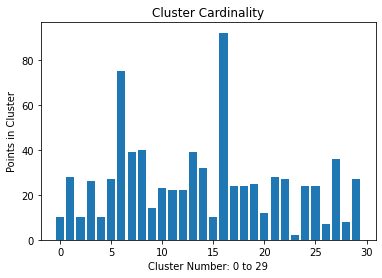

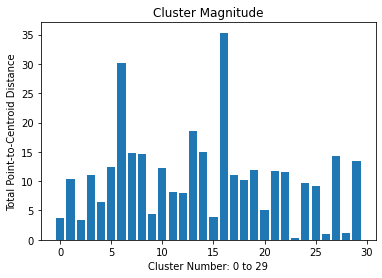

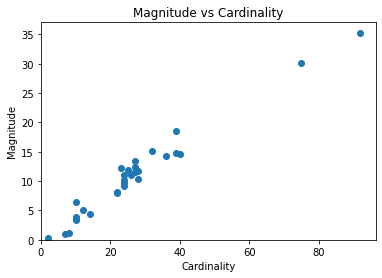

In [55]:
clusterQualityMetrics(choc_data)

k-means converged for 5 clusters after 13 iterations!
k-means converged for 7 clusters after 20 iterations!
k-means converged for 9 clusters after 13 iterations!
k-means converged for 11 clusters after 18 iterations!
k-means converged for 13 clusters after 21 iterations!
k-means converged for 15 clusters after 28 iterations!
k-means converged for 17 clusters after 14 iterations!
k-means converged for 19 clusters after 15 iterations!
k-means converged for 21 clusters after 12 iterations!
k-means converged for 23 clusters after 16 iterations!
k-means converged for 25 clusters after 22 iterations!
k-means converged for 27 clusters after 19 iterations!
k-means converged for 29 clusters after 12 iterations!
k-means converged for 31 clusters after 19 iterations!
k-means converged for 33 clusters after 14 iterations!
k-means converged for 35 clusters after 17 iterations!
k-means converged for 37 clusters after 12 iterations!
k-means converged for 39 clusters after 20 iterations!
k-means conve

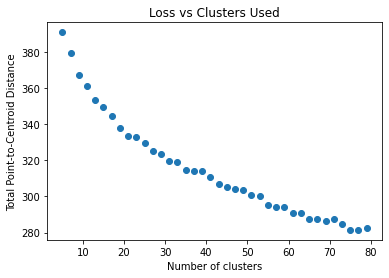

In [56]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 80  # @param
kstep = 2  # @param
lossVsClusters(kmin, kmax, kstep, choc_data)